# Quiz 1 | Katie Hahm | 10/16/20

## Problem 1

This dataset was curated (in my room!) by taking measurements from 3 high sensitivity accelerometers in the corners of a room, 
and bouncing a ball at 6 different locations. The floor material is hardwood. There are 80 datapoints. From the accelerometer
signals, I used an algorithm to find the peaks and onsets of each impact. The difference in time delays and difference in 
magnitudes of voltage peaks were recorded. For example, if sensor 1 detected the impact at 500 ms, sensor 2 at 531 ms, and 
sensor 3 at 520 ms, the time delays would be recorded as [0, 31, 20]. 
    

The goal of this research is to localize a home resident's footsteps. Localizing can detect routine habits in a resident. If a resident changes from this habit and starts spending more time alone and a long time in bed, the system can alert the resident that they may be experiencing depression. The goal is not to diagnose, but to suggest to the resident of the possibility of depression.

Example of signal:


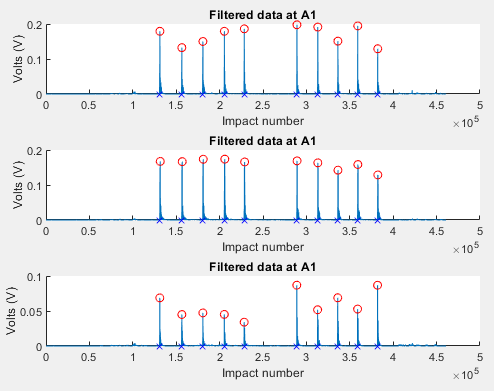

In [69]:
Image("signalEx.png")

In [1]:
# imports... nothing to see here

import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn import datasets, svm, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Problem 1a: Workflow Management

This is the same workflow from PS1.

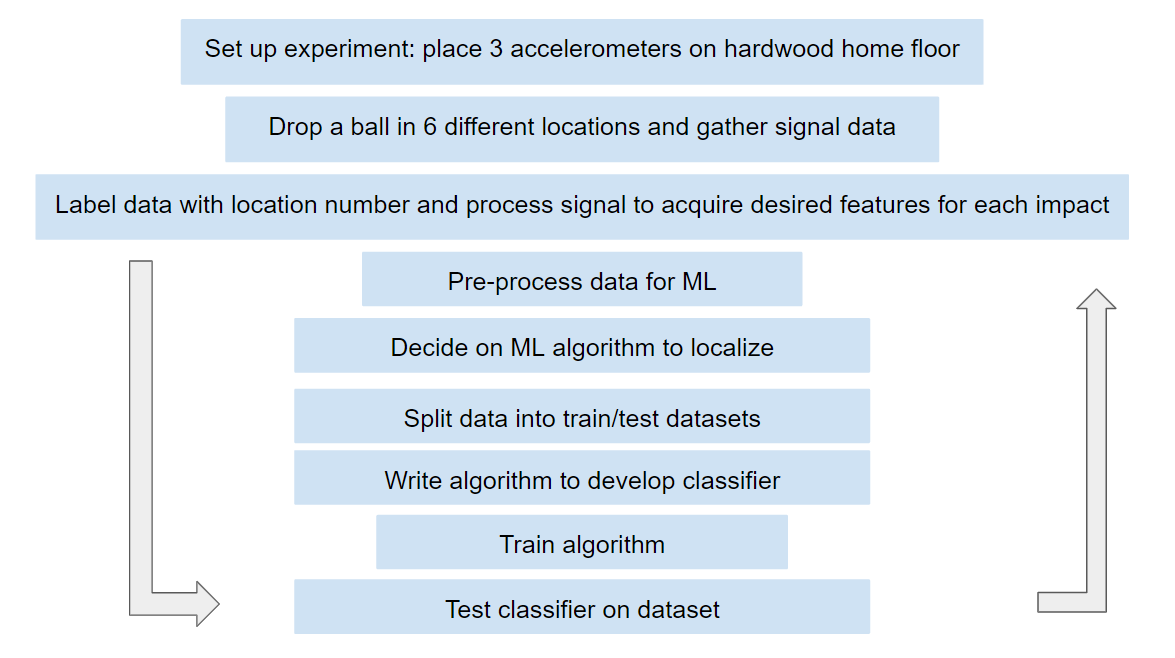

In [51]:
Image("workflow2ball.png")

## Problem 1b) Data Curation

Data is recorded on a csv file. The data needs to be converted from strings to numbers. The input data needs to be normalized such that the total magnitudes and total time delays at each sensor are normalized. We want to consider that some sensors may be at a more flexible floorboard, or any other irregularities, so the magnitudes may not be comparable raw. There are no negative numbers in the input data (the smallest voltage or time is subtracted from
the two other sensors) so we can make the inputs range from 0 to 1.


In [71]:
# read csv file
data = pd.read_csv('quiz1data.csv',header=None)
data

,0,1,2,3,4,5,6
0,mag_diff_1,mag_diff_2,mag_diff_3,diff_1,diff_2,diff_3,Var3
1,0.0363237071890133,0.165412736629753,0,1.09375,0,1.015625,1
2,0.0615863656132072,0.162507700924498,0,0.546875,0,0.703125,1
3,0.0271562898658369,0.152189083652425,0,0.625,0,0.703125,1
4,0.0164587588642653,0.116054728430749,0,0.3125,0,0.390625,1
...,...,...,...,...,...,...,...
76,0.400670110658333,0.17451167522514,0,0,0.078125,1.09375,2
77,0.331015711635809,0.17266405130083,0,0.078125,0,1.015625,2
78,0.242149713646188,0.225040887216408,0,0.546875,0,0.9375,2
79,0.774775833410796,0.279286867983786,0,0.078125,0,1.328125,2


In [4]:
# adapted from week2 XRD_dimensionlity_demo
# Data normalization from 0 to 1 for double column dataframe
def normdata(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1//2])
    for i in range(w1//2):
        ndata[:,i]=(data[:,2*i+1]-min(data[:,2*i+1]))/(max(data[:,2*i+1])-min(data[:,2*i+1]))
    return ndata
#data normalization from 0 to 1 for single column dataframe
def normdatasingle(data):
    (len1,w1) = np.shape(data)
    ndata = np.zeros([len1,w1])
    for i in range(w1):
        if (max(data[:,i])-min(data[:,i])) != 0:
            ndata[:,i]=(data[:,i]-min(data[:,i]))/(max(data[:,i])-min(data[:,i]))
    return ndata

The labels are squares of floor tiles labeled 1-6. These numbers are arbitrary, and floor tile 1 is NOT < tile 3. To make sure the algorithm does not make these inferences, we will use one-hot encoding for the output labels.

In [5]:
data_labels = data.iloc[0]
# take out the first row
data = data.drop(data.index[0])
data = data.apply(pd.to_numeric, errors='coerce')
# convert from pandas dataframe to numpy array
dataM = pd.DataFrame(data).to_numpy()
sh = dataM.shape
nrows = sh[0]
ncols = sh[1]

# normalize inputs
outputs = dataM[:,ncols-1]
inputs = dataM[:,0:ncols-1]
inputsNorm = normdatasingle(inputs)

# one-hot encoding labels
oneHotY = np.zeros((nrows,6))
for i in range(nrows):
    lbl = np.zeros(6)
    outputVal = outputs[i]
    lbl[int(outputVal-1)] = 1
    oneHotY[i,:] = lbl

## Problem 1c: Data Visualization

This dataset is imbalanced. There are about 20 more data points for floor tile 2 than for all the others. At the end of this notebook, I will compare the classification accuracy between this dataset and the dataset after omitting the 20 extra data points.

Text(0, 0.5, 'frequency')

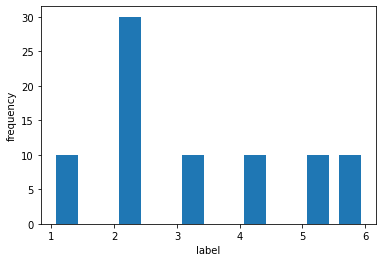

In [6]:
plt.hist (outputs, rwidth = 0.7)
plt.xlabel ('label')
plt.ylabel('frequency')

Visualize normalized input data distribution

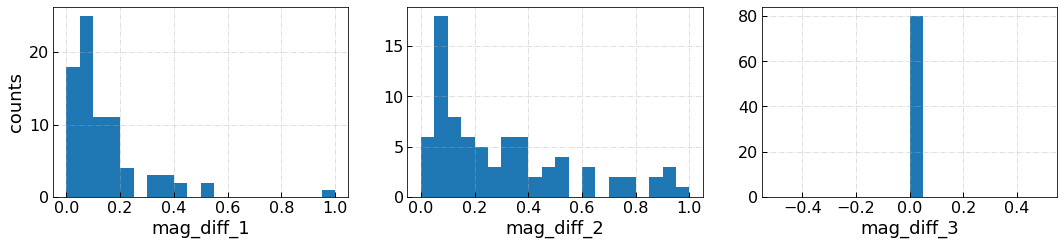

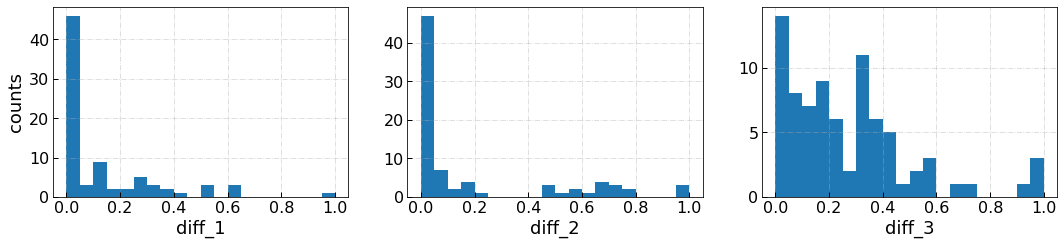

In [7]:
# adapted from week 3 data_visual_cement_dataset
n_col = ncols//2
for n in np.arange(0, 6, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n < len(data_labels)-1:
            axes[i].hist(inputsNorm[:,n], bins = 20)
            axes[i].set_xlabel(data_labels[n], fontsize = 18)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

Visualize the dependence between each input feature and the label

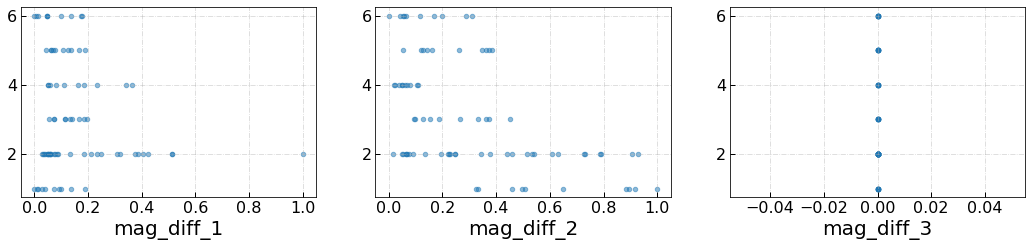

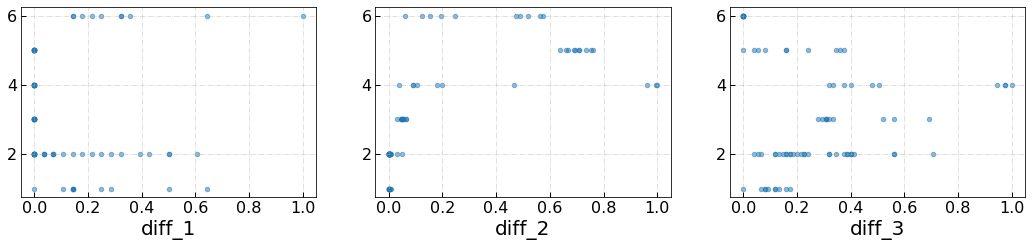

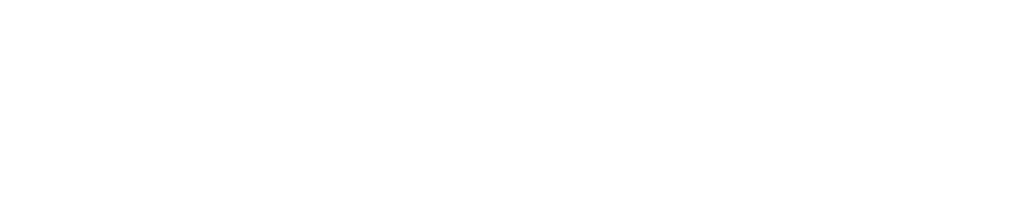

In [8]:
n_col = 3 # num of columns per row in the figure
y_indx = -1 
color_indx = -2 
fs = 20

cmap = plt.get_cmap('coolwarm', 10)

for n in np.arange(0, ncols, n_col):
        fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
        for i in np.arange(n_col):
            if n < len(data_labels)-1:
                im = axes[i].scatter(inputsNorm[:,n],outputs, s = 20, cmap=cmap, alpha =0.5, edgecolors = 'face')
                axes[i].set_xlabel(data_labels[n], fontsize = fs)
            else:
                axes[i].axis("off")
            n = n+1      
#         axes[0].set_ylabel(data_labels[y_indx], fontsize = fs)
        for i in range(len(axes)):
            axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            axes[i].grid(True, linestyle='-.')
        plt.show()

Pearson Correlation Coefficients

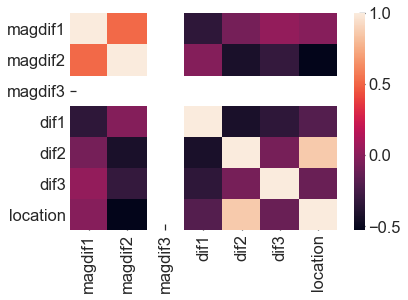

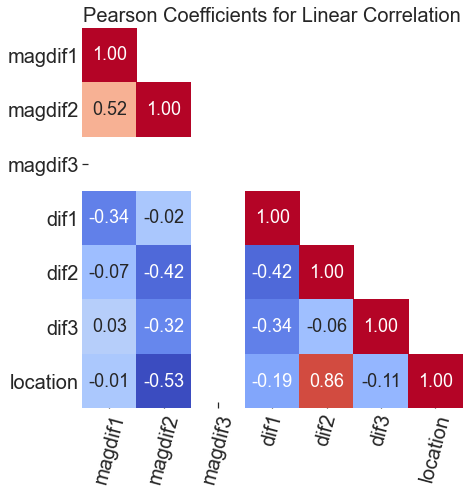

In [53]:
df = pd.read_csv('quiz1data.csv')
df_cols = ['magdif1','magdif2','magdif3','dif1','dif2','dif3','location']
df.columns = df_cols
df.corr(method='spearman').round(2)
sns.heatmap(df.corr(method='spearman'))
corr = df.corr(method='spearman')#'spearman'
corr.columns = df_cols
df_len = len(df_cols)
fs = 20


fig, ax=plt.subplots(figsize=(df_len,df_len))
sns.set(font_scale=1.5)
sns.set_style("ticks",{'xtick.direction': 'in', # set the style of the plot using seaborn
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})
mask = np.triu(np.ones_like(corr, dtype=np.bool),k=1)
cmap = plt.get_cmap('coolwarm')
sns.heatmap(corr, mask = mask, cbar_kws={"shrink": .2}, annot=True, fmt='.2f', 
            cmap=cmap, cbar=False, ax=ax, square=True)
ax.set_xlim(0, df_len)
ax.set_ylim(df_len, 0)
ax.set_title("Pearson Coefficients for Linear Correlation", fontsize = 20)
plt.xticks(rotation=75, fontsize = fs)
plt.yticks(rotation=0, fontsize = fs) 
plt.show()

## Proble 1d: Algorithm Selection & Comparison

Input Variables: 
    - x3 Time delays between three sensors
    - x3 magnitude differences between three sensors

Output Variables: 
    - Location labeled 1-6

The input variables were calculated through an algorithm that found peaks in signal data. Based on a threshold, it would find the onset of the impact for every peak detected. The decision to use these as features were based on time difference of arrival methods. The irregularities in the flooring means for every impact, there is not a constant speed of vibration through wood to find the location of the impact. However, my hypothesis is that the irregularities are not dynamically changing. So I will use machine learning algorithms to locate based on when a sensor first feels the impact (onset) and how much it feels the impact (peak).

Some ethical considerations are that keeping an "eye" on residents can breach privacy. However, it does not use any cameras and the information collected is just footsteps, which is minimal. This is similar to already existing devices like the fitbit and nest devices, but making it not wearable so the resident does not have to keep it on them at all times. Prior work involves using IR cameras to monitor resident's activity, so this approach is more protective of privacy.

Another consideration is that we cannot account for all types of people and their footsteps. I am currently limited to using myself as the walking test subject due to covid. We will have to keep this in mind, and further develop the algorithm in the future by collecting data from a more diverse population. 

In [10]:
enc = OneHotEncoder(sparse=False)
y_onehot = enc.fit_transform(outputs.reshape(-1,1))

We only have 80 datapoints - this is a very small amount of data. To improve our output, we will use 10-fold cross validation.

In [11]:
n_fold = 10
k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=30)


In [55]:
# adapted from week 1 classification_demo
# Multinomial Naive Bayes Classifier
def naive_bayes_classifier(train_x, train_y):
    from sklearn.naive_bayes import MultinomialNB
    model = MultinomialNB(alpha=0.01)
    model.fit(train_x, train_y)
    return model


# KNN Classifier
def knn_classifier(train_x, train_y):
    from sklearn.neighbors import KNeighborsClassifier
    model = KNeighborsClassifier(n_neighbors=4)
    model.fit(train_x, train_y)
    return model



# Random Forest Classifier
def random_forest_classifier(train_x, train_y):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(train_x, train_y)
    return model


# Decision Tree Classifier
def decision_tree_classifier(train_x, train_y):
    from sklearn import tree
    model = tree.DecisionTreeClassifier()
    model.fit(train_x, train_y)
    return model


# GBDT(Gradient Boosting Decision Tree) Classifier
def gradient_boosting_classifier(train_x, train_y):
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(n_estimators=200)
    model.fit(train_x, train_y)
    return model


# SVM Classifier
def svm_classifier(train_x, train_y):
    from sklearn.svm import SVC
    model = SVC(kernel='rbf', probability=True)
    model.fit(train_x, train_y)
    return model



 # 3 layer neural network classficiation
def mlp_classifier(train_x,train_y):
    from sklearn.neural_network import MLPClassifier
    model =  MLPClassifier(hidden_layer_sizes=(256,128,32), max_iter=20, alpha=1e-4,
                    solver='ada,', verbose=10, tol=1e-6, random_state=1,
                    learning_rate_init=.1)
    model.fit(train_x,train_y)
    return model

In [13]:
# adapted from data_visual_cement_dataset
def plot_predictions(y, y_hat, labels): 
    plt.rcParams.update({'font.size': 20, 'font.sans-serif':'arial'})
    y, y_hat, labels = list(
        map(
            lambda l: l if isinstance(l, list) else [l],
            [y, y_hat, labels]))
    color_list = ['blue', 'red']
    n_plots = len(y)
    y_min = min([min(z) for z in y])
    y_max = max([max(z) for z in y])
    lims = (y_min, y_max)
    fig, ax = plt.subplots(
        1, n_plots, figsize=(7*n_plots, 6),
        squeeze=False, sharex=True, sharey=True)
    for axis, target, prediction, label, color in zip(ax[0, :], y, y_hat, labels, color_list):
        # Scatter plot
        axis.scatter(target, prediction, alpha=0.3, c = color)

        # Title and labels
        rmse_value = np.sqrt(mean_squared_error(target, prediction))
        title = label + " (RMSE=%.3f)" % rmse_value
        axis.set_title(title)
        axis.set_xlabel('Target Location')
        axis.set_ylabel('Predicted Location')
        axis.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        axis.yaxis.set_tick_params(which='both', labelleft=True)

    plt.subplots_adjust(wspace = 0.3)
    plt.show()

In [14]:
def unOneHot(yHot):
    n = len(yHot)
    y = np.zeros(n)
    for i in range(n):
        labelidx = np.argmax(yHot[i,:],axis=0)
        y[i] = labelidx+1
    return y

I chose to implement classification because my outputs are categorical (locations 1-6 only). I will compare decision tree classifier, gradient boosting classifier, and knn.

In [60]:
# adapted from XRD_dimensionality_demo
accuracy_all = np.zeros(n_fold)
num_acc = [0,0,0,0,0,0]
div_count = [0,0,0,0,0,0]
for k, (train, test) in enumerate(k_fold.split(inputsNorm, y_onehot)):
    xTrain = inputsNorm[train]
    yTrain = y_onehot[train]
    # decide ML algorithm here
    model = decision_tree_classifier(xTrain,yTrain)
    xTest = inputsNorm[test]
    yTest = y_onehot[test]
    predicted = model.predict(xTest)
    yTestNum = unOneHot(yTest)
    yhatTestNum = unOneHot(predicted)
    accuracy = metrics.accuracy_score(yTestNum, yhatTestNum)
    accuracy_all[k] = accuracy
    # finding accuracy for each location
    num_acc_temp = []
    for i in range(7):
        if i > 0:
            idx = np.where(yTestNum == i)
            if len(idx[0])>0:
                num_acc_temp.append(metrics.accuracy_score(yTestNum[idx],yhatTestNum[idx]))
                div_count[i-1] += 1
            else:
                num_acc_temp.append(0)
    num_acc = [num_acc[i]+num_acc_temp[i] for i in range(6)]
    print ('classification accuracy : %.2f%%' % (100 * accuracy))

print('#####')
print('Decision Tree Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))
print('#####')
print('Prediction accuracy for each location:')
print([num_acc[i]/div_count[i] for i in range(6)])

classification accuracy : 100.00%
classification accuracy : 62.50%
classification accuracy : 75.00%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 75.00%
classification accuracy : 75.00%
classification accuracy : 75.00%
classification accuracy : 62.50%
#####
Decision Tree Cross-validation results:
Folds: 10, mean acc: 0.825
#####
Prediction accuracy for each location:
[0.7916666666666666, 0.8266666666666665, 1.0, 0.5555555555555556, 0.9444444444444443, 1.0]


[1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 4. 5. 5. 5. 5. 6. 6.
 6. 6. 6. 1. 1. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4. 5. 5. 5.
 5. 6. 6. 6. 6. 6. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 4. 4. 4. 4. 4. 5. 5. 5. 5. 6. 6.
 6. 6. 6. 1. 1. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4. 5. 5. 5.
 5. 6. 6. 6. 6. 6. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[1. 3. 5. 2. 4. 5. 2. 2.]
[1. 3. 5. 1. 3. 5. 1. 2.]


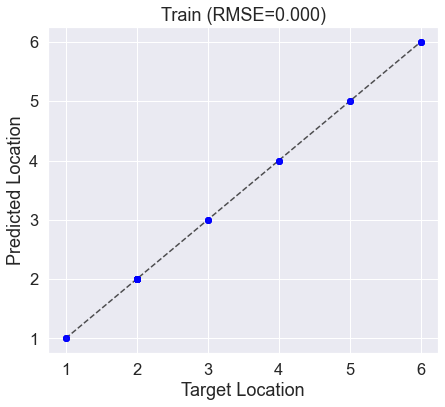

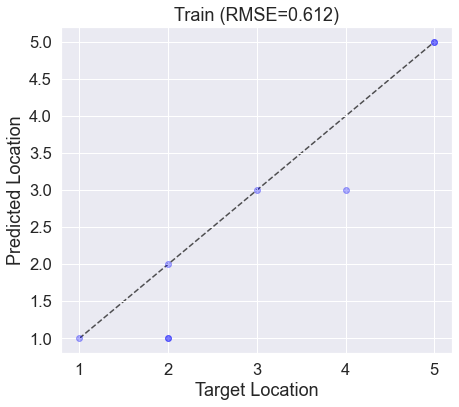

In [67]:
yTrainNum = unOneHot(yTrain)
predictTrainNum = unOneHot(model.predict(xTrain))
yTestNum = unOneHot(yTest)
predictTestNum = unOneHot(predicted)
plot_predictions(yTrainNum, predictTrainNum,'Train')
plot_predictions(yTestNum, predictTestNum,'Test')

The test data performs well. The two incorrect predictions are still only 1 location away from the correct location. This is important because we can still predict a resident's behavior if the location is only 1 off (typically 1-2 ft), but if it is wildly off, ex. 4 locations distance, then the habit generating algorithm will be faulty. 

The train data performed too perfectly on the model. This means the model is overfitting, but this may be due to the small amount of datapoints. I will be using a larger dataset for the class project, so I will aim to prevent overfitting on that model.

I used RMSE as the loss function because it has a physical meaning - the absolute distance between the predicted location and the target location. This gives me a good intuitition for how well the model is working, as described above.

In [56]:
accuracy_all = np.zeros(n_fold)
num_acc = [0,0,0,0,0,0]
div_count = [0,0,0,0,0,0]
for k, (train, test) in enumerate(k_fold.split(inputsNorm, y_onehot)):
    xTrain = inputsNorm[train]
    yTrain = y_onehot[train]
    model = gradient_boosting_classifier(xTrain,outputs[train])
    xTest = inputsNorm[test]
    yTest = outputs[test]
    predicted = model.predict(xTest)
    yTestNum = yTest
    yhatTestNum = predicted
    accuracy = metrics.accuracy_score(yTestNum, yhatTestNum)
    accuracy_all[k] = accuracy
    # finding accuracy for each location
    num_acc_temp = []
    for i in range(7):
        if i > 0:
            idx = np.where(yTest == i)
            if len(idx[0])>0:
                num_acc_temp.append(metrics.accuracy_score(yTest[idx],predicted[idx]))
                div_count[i-1] += 1
            else:
                num_acc_temp.append(0)
    num_acc = [num_acc[i]+num_acc_temp[i] for i in range(6)]
    print ('classification accuracy : %.2f%%' % (100 * accuracy))

print('#####')
print('GBD Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))
print('#####')
print('Prediction accuracy for each location:')
print([num_acc[i]/div_count[i] for i in range(6)])


classification accuracy : 87.50%
classification accuracy : 87.50%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 87.50%
classification accuracy : 75.00%
classification accuracy : 87.50%
classification accuracy : 37.50%
#####
GBD Cross-validation results:
Folds: 10, mean acc: 0.863
#####
Prediction accuracy for each location:
[0.4583333333333333, 0.86, 1.0, 0.8333333333333334, 1.0, 1.0]


In [57]:
accuracy_all = np.zeros(n_fold)
num_acc = [0,0,0,0,0,0]
div_count = [0,0,0,0,0,0]
for k, (train, test) in enumerate(k_fold.split(inputsNorm, y_onehot)):
    xTrain = inputsNorm[train]
    yTrain = y_onehot[train]
    model = knn_classifier(xTrain,outputs[train])
    xTest = inputsNorm[test]
    yTest = outputs[test]
    predicted = model.predict(xTest)
    yTestNum = yTest
    yhatTestNum = predicted
    accuracy = metrics.accuracy_score(yTestNum, yhatTestNum)
    accuracy_all[k] = accuracy
    # finding accuracy for each location
    num_acc_temp = []
    for i in range(7):
        if i > 0:
            idx = np.where(yTest == i)
            if len(idx[0])>0:
                num_acc_temp.append(metrics.accuracy_score(yTest[idx],predicted[idx]))
                div_count[i-1] += 1
            else:
                num_acc_temp.append(0)
    num_acc = [num_acc[i]+num_acc_temp[i] for i in range(6)]
    print ('classification accuracy : %.2f%%' % (100 * accuracy))

print('#####')
print('KNN Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))
print('#####')
print('Prediction accuracy for each location:')
print([num_acc[i]/div_count[i] for i in range(6)])


classification accuracy : 62.50%
classification accuracy : 62.50%
classification accuracy : 62.50%
classification accuracy : 50.00%
classification accuracy : 87.50%
classification accuracy : 75.00%
classification accuracy : 87.50%
classification accuracy : 75.00%
classification accuracy : 37.50%
classification accuracy : 75.00%
#####
KNN Cross-validation results:
Folds: 10, mean acc: 0.675
#####
Prediction accuracy for each location:
[0.7916666666666666, 0.73, 0.38095238095238093, 0.5555555555555556, 1.0, 0.7142857142857143]


Increasing the hyperparameter for gradient boosting classifier did not change the accuracy. My dataset is very small, so the number of estimators was already high enough. Similarly, increasing the knn number of neighbors improved the accuracy by a small amount. 

KNN performed the worst out of the three. Gradient boosting classifier performed the best, but decision tree was very close in performance, but took much less time to execute. 

I will compare the performance of decision tree between the complete dataset and the dataset with the 20 extra datapoints at location 2 omitted.

In [59]:
# adapted from XRD_dimensionality_demo
accuracy_all = np.zeros(n_fold)
num_acc = [0,0,0,0,0,0]
div_count = [0,0,0,0,0,0]
inputsNormShort = inputsNorm[0:60,:]
y_onehotShort = y_onehot[0:60,:]
for k, (train, test) in enumerate(k_fold.split(inputsNormShort, y_onehotShort)):
    xTrain = inputsNormShort[train]
    yTrain = y_onehotShort[train]
    # decide ML algorithm here
    model = decision_tree_classifier(xTrain,yTrain)
    xTest = inputsNormShort[test]
    yTest = y_onehotShort[test]
    predicted = model.predict(xTest)
    yTestNum = unOneHot(yTest)
    yhatTestNum = unOneHot(predicted)
    accuracy = metrics.accuracy_score(yTestNum, yhatTestNum)
    accuracy_all[k] = accuracy
    # finding accuracy for each location
    num_acc_temp = []
    for i in range(7):
        if i > 0:
            idx = np.where(yTestNum == i)
            if len(idx[0])>0:
                num_acc_temp.append(metrics.accuracy_score(yTestNum[idx],yhatTestNum[idx]))
                div_count[i-1] += 1
            else:
                num_acc_temp.append(0)
    num_acc = [num_acc[i]+num_acc_temp[i] for i in range(6)]
    print ('classification accuracy : %.2f%%' % (100 * accuracy))

print('#####')
print('Decision Tree Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))
print('#####')
print('Prediction accuracy for each location:')
print([num_acc[i]/div_count[i] for i in range(6)])

classification accuracy : 66.67%
classification accuracy : 83.33%
classification accuracy : 50.00%
classification accuracy : 83.33%
classification accuracy : 66.67%
classification accuracy : 66.67%
classification accuracy : 66.67%
classification accuracy : 66.67%
classification accuracy : 100.00%
classification accuracy : 66.67%
#####
Decision Tree Cross-validation results:
Folds: 10, mean acc: 0.717
#####
Prediction accuracy for each location:
[0.9047619047619048, 0.5, 0.8095238095238094, 0.6875, 0.75, 0.8571428571428571]


This shortened dataset performed worse than the full dataset. The other locations had similar prediction accuracy to the full dataset, but location 2, which was the location of the omitted datapoints, performed much worse. This is as expected.

## Problem 2

My class project will be extending the experiment described in problem 1. The dataset used previously was curated by bouncing a ball at different locations. The dataset for the class project will be actual footsteps. These signals will be more messy - heel/toe strikes affect the peak finding algorithm, the magnitudes of each impact is less controlled, and the other foot is still on the ground which can cause a dampening effect. Again, we want to classify the location of these footsteps. 

## Problem 2a: Workflow Management

This workflow diagram is similar to that of problem 1, except now we are using footsteps for impacts instead of a ball bounce.

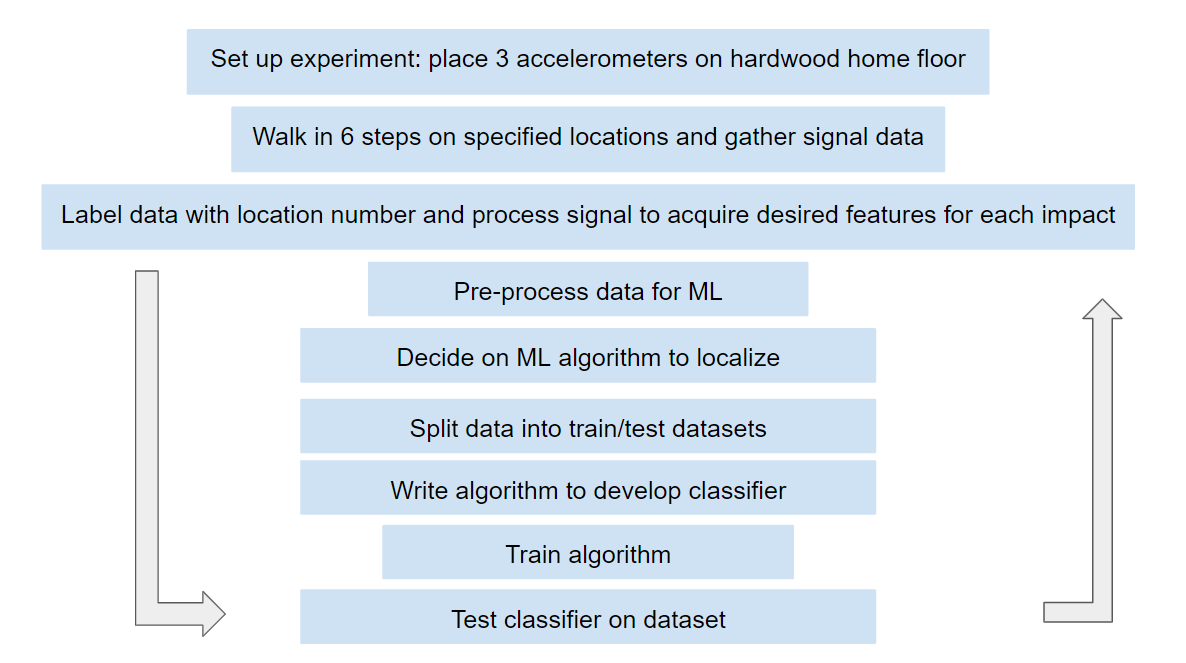

In [70]:
Image("workflow2.png")

## Problem 2b: Data Curation

I have already curated data that is about 60 datapoints long. The process is streamlined so that the labeling is done by a function. I walk in the same path each time, so the location is the same for each data curation cycle. 

For this project, I hope to make the dataset at least 180 datapoints long, so there are 30 points for each location. It takes about 1 minute to get 6 datapoints, so it will take about 20 minutes to curate the entire dataset. 

The risks to acquiring this dataset is that the apartment I live in is sensitive to other residents' movement. For example, my sensors can feel my washing machine running, or my roommate walking in a different room. To mitigate this, I will acquire data at times when people are less likely to be home, and delete the data if it detects other sources of movement. Another risk is that the sensors will detect different signal if the furniture of my room changes, but I am fully in control of this room so I will keep the furniture consistant throughout the data curation process. 

## Problem 2c: Data Visualization

Similar to the data visualization tools in problem 1, I will use the pearson correlation coefficient matrix to visualize the relation between the variables. I will also use scatter plots to see the correlation between each input feature and the output label. I will plot the predicted outputs vs ground truth on a confusion matrix to show that even if a datapoint is misclassified, we can visualize far the predicted location is from the actual location.

## Problem 2d: Algorithm Selection & Comparison

The task will be similar - I want to predict the location of a footfall based on the input features. I will be addeding 6 more input features - the absolute value of the voltage peaks, and the highest two peaks divided by the lowest peak. The only peak value is the lowest peak subtracted from the other two, but this does not fully take into account the magnitude of the impact. It may be leaving out information about how hard the floor was hit.

I will use classification for this problem. I will test with gradient boost and decision tree algorithms again, and tune the hyperparameters accordingly.

## Problem 2e: Define the Gap

In the future, it would be helpful for me to implement unsupervised learning. A room will often be furnished differently and have different floor materials. It is unrealistic to gather enough data for every case. It is more reasonable to ask the resident to walk in a few specified places in the beginning to tune the algorithm (semi-supervised learning), and then leave the algorithm to sort out the data as the resident goes about their day. This can also be helpful for when a furniture is moved and therefore the signals feel the impacts differently. The algorithm will have to constantly keep learning, so clustering without labels will be a more appropriate algorithm.

#### bogus after this, please disregard! ####

In [181]:
accuracy_all = np.zeros(n_fold)
for k, (train, test) in enumerate(k_fold.split(inputsNorm, y_onehot)):
    xTrain = inputsNorm[train]
    yTrain = y_onehot[train]
    # decide ML algorithm here
    regressor = LinearRegression()
    regressor.fit(xTrain, yTrain)
    y_hat_train = regressor.predict(xTrain)
    xTest = inputsNorm[test]
    yTest = y_onehot[test]
    y_hat_test = regressor.predict(xTest)
    yTestNum = unOneHot(yTest)
    yhatTestNum = unOneHot(y_hat_test)
    accuracy = metrics.accuracy_score(yTestNum, yhatTestNum)
    accuracy_all[k] = accuracy
    print ('classification accuracy : %.2f%%' % (100 * accuracy))

print('Regression Cross-validation results:')
print('Folds: %i, mean acc: %.3f' % (len(accuracy_all), np.mean(np.abs(accuracy_all))))

classification accuracy : 75.00%
classification accuracy : 50.00%
classification accuracy : 75.00%
classification accuracy : 75.00%
classification accuracy : 87.50%
classification accuracy : 62.50%
classification accuracy : 87.50%
classification accuracy : 75.00%
classification accuracy : 50.00%
classification accuracy : 75.00%
Regression Cross-validation results:
Folds: 10, mean acc: 0.713


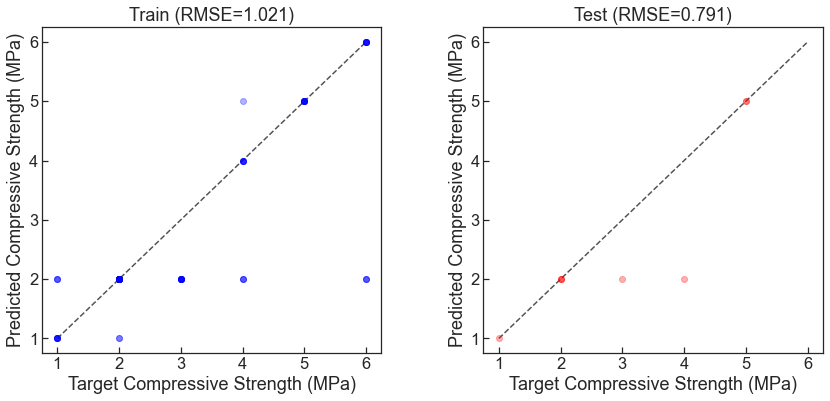

In [182]:
yTrainNum = unOneHot(yTrain)
yhattrainNum = unOneHot(y_hat_train)
plot_predictions([yTrainNum, yTestNum], [yhattrainNum, yhatTestNum],    labels=['Train', 'Test'])

In [72]:
# bogus after this
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y= df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2 )

In [73]:

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)  # Training set predictions
y_hat_test = regressor.predict(X_test)  # Test set predictions

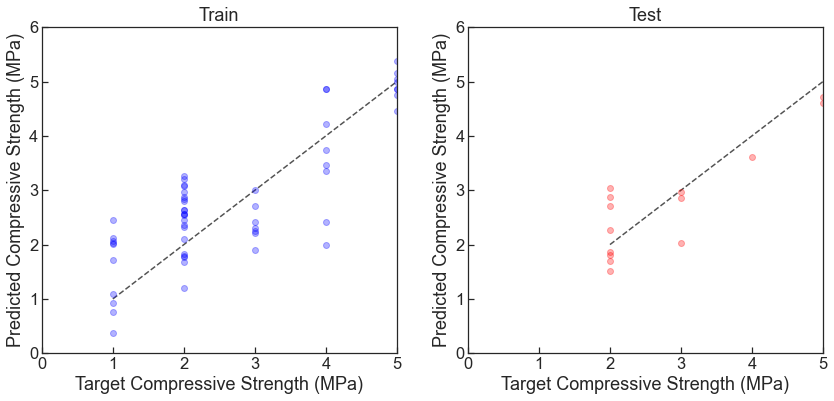

In [76]:

fig,ax = plt.subplots(1,2,figsize=(14,6))
#set font size
plt.rcParams.update({'font.size': 20})
#scatter plot
ax[0].scatter (y_train,y_hat_train,alpha=0.3,c='blue')
ax[1].scatter (y_test,y_hat_test,alpha=0.3,c='red')
#line plot for the visual
ax[0].plot ((min(y_train),max(y_train)),(min(y_train),max(y_train)),'k--', alpha=0.75, zorder=0)
ax[1].plot ((min(y_test),max(y_test)),(min(y_test),max(y_test)),'k--', alpha=0.75, zorder=0)
#label and title
ax[0].set_xlim(0,5)
ax[0].set_ylim(0,6)
ax[1].set_xlim(0,5)
ax[1].set_ylim(0,6)
ax[0].set_xlabel ('Target Compressive Strength (MPa)')
ax[0].set_ylabel ('Predicted Compressive Strength (MPa)')
ax[1].set_xlabel ('Target Compressive Strength (MPa)')
ax[1].set_ylabel ('Predicted Compressive Strength (MPa)')
ax[0].set_title ('Train')
ax[1].set_title ('Test')
plt.show()


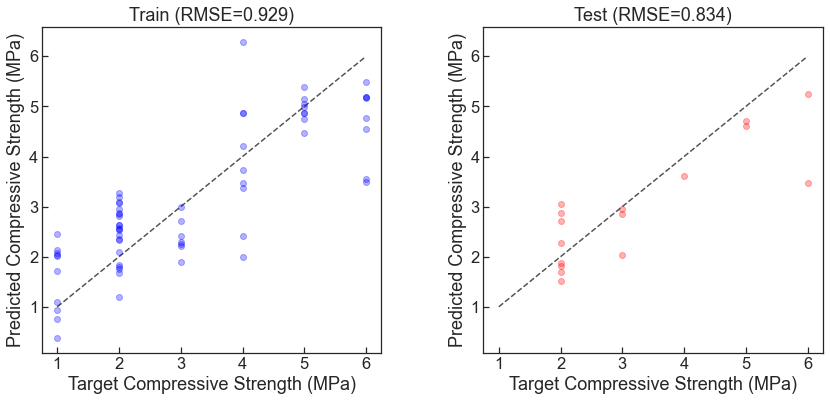

In [78]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

In [79]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree=3
regressor=make_pipeline(PolynomialFeatures(degree),LinearRegression())
regressor.fit(X,y)

regressor.fit(X_train, y_train)


y_hat_train = regressor.predict(X_train)  # Training set predictions
y_hat_test = regressor.predict(X_test)  # Test set predictions

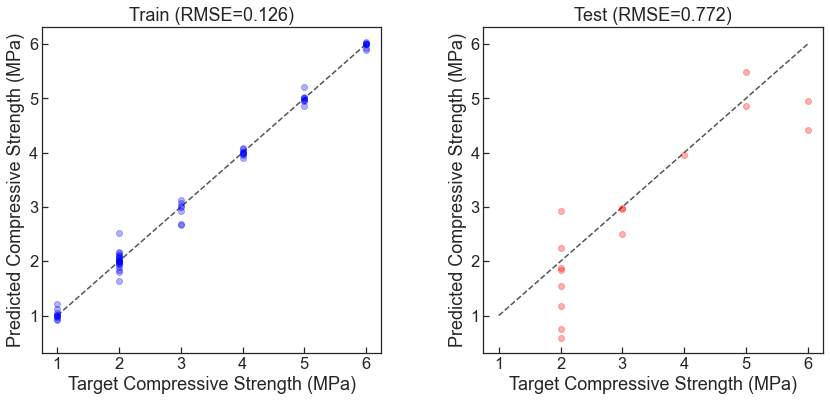

In [80]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

In [81]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree


tree_reg = DecisionTreeRegressor(max_depth=3)

tree_reg.fit(X_train, y_train)
y_hat_train = tree_reg.predict(X_train)  # Training set predictions
y_hat_test = tree_reg.predict(X_test)  # Test set predictions

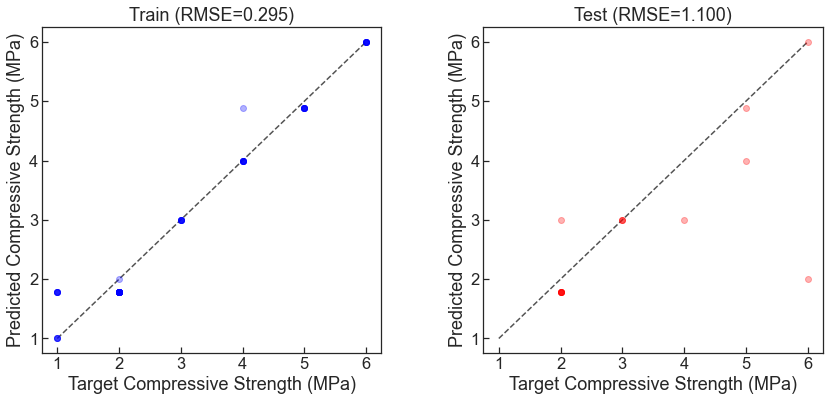

In [82]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

cross validation + one hot

In [99]:
enc = OneHotEncoder(sparse=False)
y_onehot = enc.fit_transform(outputs.reshape(-1,1))
n_fold = 10
k_fold = KFold(n_splits=n_fold, shuffle=True,random_state=30)
test_classifier = ['RF']
classifiers = {'NB':naive_bayes_classifier,   
                   'KNN' :knn_classifier,                      
                   'RF':random_forest_classifier,  
                   'DT':decision_tree_classifier,  
                   'SVM':svm_classifier,                    
                   'GBDT':gradient_boosting_classifier,
                   'NN':mlp_classifier,                   
                   
    }

In [104]:
X_exp = inputsNorm
y_exp = y_onehot
accuracy_exp = np.empty((n_fold,1)) 
# start_time = time.time()   
for classifier in test_classifier: 
    print ('******************* %s ********************' % test_classifier)
    for k, (train, test) in enumerate(k_fold.split(X_exp, y_exp)):
        temp_x = X_exp[train]
        temp_y = y_exp[train]
        model = decision_tree_classifier(temp_x,temp_y)
        test_x = X_exp[test]
        test_y = y_exp[test]
        predicted = model.predict(test_x)
        accuracy = metrics.accuracy_score(test_y, predicted)  
        print ('classification accuracy : %.2f%%' % (100 * accuracy))
#             print(train)
#             print(test)
#             print(k)
#             #data augmentation to experimenal traning dataset
#             temp_x = X_exp[train]
#             temp_y = y_exp[train]
#             exp_train_x,exp_train_y = exp_augdata(temp_x.T,exp_aug_num ,temp_y)
#             #combine theorectical and experimenal dataset for training
#             train_combine = np.concatenate((X_th,exp_train_x.T))
#             train_y = np.concatenate((y_th,exp_train_y))                                 
    
#             #predict experimental prediction accuracy
#             if classifier == 'CNN':
#                 train_y = enc.transform(train_y.reshape(-1,1))
#                 model = classifiers[classifier](train_combine, train_y) 
#                 predict_exp = model.predict(np.expand_dims(X_exp[test],2))
#                 predict_exp = enc.inverse_transform(predict_exp)
#             else:
#                 model = classifiers[classifier](train_combine, train_y) 
#                 predict_exp = model.predict(X_exp[test])
            
#             accuracy_exp[k] = accuracy_score(y_exp[test], predict_exp)  
#             print ('accuracy_exp: %.2f%%' % (100 * accuracy_exp[k]))

# print ('CV  took %fs!' % (time.time() - start_time) )
# print('Cross-validation results:')
# print('Folds: %i, mean acc: %.3f' % (len(accuracy_exp), np.mean(np.abs(accuracy_exp))))

******************* ['RF'] ********************
classification accuracy : 100.00%
classification accuracy : 37.50%
classification accuracy : 75.00%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 100.00%
classification accuracy : 75.00%
classification accuracy : 62.50%
classification accuracy : 75.00%
classification accuracy : 62.50%
